# Filter Example

This example demonstrates the connection between MKS and signal
processing for a 1D filter. It shows that the filter is in fact the
same as the influence coefficients and, thus, applying the `predict`
function provided by the `pymks.fmks.localization` is in essence just applying a filter.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from toolz.curried import pipe, compose, map, curry
from pymks.fmks.bases.primitive import discretize
from pymks.fmks.localization import fit, predict, coeff_to_real
from typing import Tuple
import scipy.ndimage
import dask.array as da

Here we construct a filter, $F$, such that

$$F\left(x\right) = e^{-|x|} \cos{\left(2\pi x\right)} $$

We want to show that, if $F$ is used to generate sample calibration
data for the MKS, then the calculated influence coefficients are in
fact just $F$.

In [3]:
def filter(x):
    return np.exp(-abs(x)) * np.cos(2 * np.pi * x)

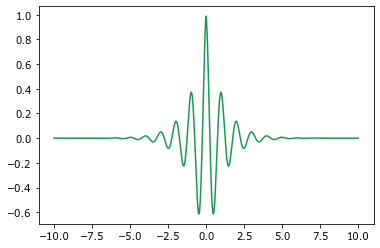

In [4]:
def fplot(x, y):
    plt.plot(x, y, color='#1a9850')
    plt.show()

io = pipe(
        np.linspace(-10.0, 10.0, 1000),
        lambda x: fplot(x, filter(x))
)

Next we generate the sample data `(X, y)` using
`scipy.ndimage.convolve`. This performs the convolution

$$ p\left[ s \right] = \sum_r F\left[r\right] X\left[r - s\right] $$

for each sample.

In [5]:
def get_x_data(n_sample, n_space):
    np.random.seed(201)
    return np.random.random((n_sample, n_space))

In [6]:
@curry
def convolve(x_sample):
    return scipy.ndimage.convolve(x_sample,
                                  filter(np.linspace(-10.0, 10.0, len(x_sample))),
                                  mode="wrap")

In [7]:
get_y_data = compose(np.array, list, map(convolve))
get_xy_data = lambda x: (x, get_y_data(x))
    
data = get_xy_data(get_x_data(50, 101))

In [8]:
print(data[0].shape, data[1].shape)

(50, 101) (50, 101)


For this problem, a basis is unnecessary, as no discretization is
required in order to reproduce the convolution with the MKS localization. Using
the `primitive_basis` with `n_state=2` is the equivalent of a
non-discretized convolution in space.

In [9]:
def fit_predict(x_data, y_data):
    basis = discretize(n_state=2)
    return pipe(
        fit(x_data, y_data, discretize),
        lambda coeff: (predict(x_data, coeff, basis), coeff)
    )

x, y = data
y_pred, coeff = fit_predict(da.from_array(x, chunks=(10, 101)),
                            da.from_array(y, chunks=(10, 101)))
print(y_pred[0, :4].compute())
print(y[0, :4])
print(coeff.shape)

[-0.41059557  0.20004566  0.61200171  0.5878077 ]
[-0.41059557  0.20004566  0.61200171  0.5878077 ]
(101, 2)


(101,)
(101, 2)


/nix/store/d9qwi2b0i0pjxvslxpfmv6dk1nrnz67i-python3.7-dask-2.10.1/lib/python3.7/site-packages/dask/array/core.py:1316: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(dtype)


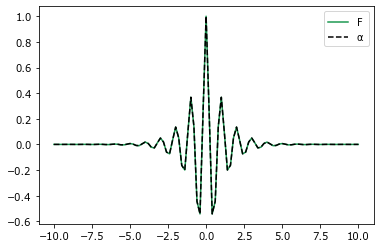

In [10]:
# NBVAL_IGNORE_OUTPUT

x = np.linspace(-10.0, 10.0, 101)
rcoeff = coeff_to_real(coeff, (101,))
print(x.shape)
print(rcoeff.shape)
plt.plot(x, filter(x), label=r'$F$', color='#1a9850')
plt.plot(x, -rcoeff[:, 0] + rcoeff[:, 1], 
         'k--', label=r'$\alpha$')
l = plt.legend()
plt.show()

In [11]:
print(y_pred[0, :4].compute())

[-0.41059557  0.20004566  0.61200171  0.5878077 ]


Some manipulation of the coefficients is required to reproduce the filter. Remember the convolution for the MKS is

$$ p \left[s\right] = \sum_{l=0}^{L-1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s - r] $$

However, when the primitive basis is selected, the `MKSLocalizationModel` solves a modified form of this. There are always redundant coefficients since

$$ \sum\limits_{l=0}^{L-1} m[l, s] = 1 $$

Thus, the regression in Fourier space must be done with categorical variables, and the regression takes the following form:


$$ \begin{split}
p [s] & = \sum_{l=0}^{L - 1} \sum_{r=0}^{S - 1} \alpha[l, r] m[l, s -r] \\
P [k] & = \sum_{l=0}^{L - 1} \beta[l, k] M[l, k] \\
&= \beta[0, k] M[0, k] + \beta[1, k] M[1, k]
\end{split}
$$

where

$$\beta[0, k] = \begin{cases}
\langle F(x) \rangle ,& \text{if } k = 0\\
0,              & \text{otherwise}
\end{cases} $$

This removes the redundancies from the regression, and we can reproduce the filter.